# seq2seq (Sequence-to-Sequence)

In [32]:
# 모델 시각화 목적 패키지 install
# !pip install pydot pydotplus graphviz

### Embedding Vector 준비
1. 영어 glove 임베딩(사전 학습) 사용 / 6b tokens, 400k vocab, uncased, 100d
2. 한국어 임베딩 (조기 훈련)

In [33]:
# !gdown 1qk-14tgVHPXT5jfRUE4Ua2ji4EXwS022

### 학습 데이터 준비

http://www.manythings.org/anki/

eng-kor 짝으로 이루어진 학습 데이터

1. Encoder 입력 데이터 eng
    - encoder_input_eng 준비    I love you
2. Decoder 출력 데이터 kor
    - 학습용 teacher-forcing 모델
        - decoder_input_kor    <sos> 난 널 사랑해
        - decoder_output_kor   난 널 사랑해 <eos>
    - 추론용 모델

In [34]:
# !gdown 17X1AF5lusy-FP-Zadm-DDpbeKIZ1cWmH -O eng_kor.txt

In [35]:
eng_inputs = []  # 인코더 입력
kor_inputs = []  # 디코더 입력
kor_targets = [] # 디코더 출력

with open('eng_kor.txt', 'r', encoding='utf-8') as f:
    for line in f:
        eng, kor, _ = line.split('\t')

        kor_input = '<sos> ' + kor
        kor_target = kor + ' <eos>'

        eng_inputs.append(eng)
        kor_inputs.append(kor_input)
        kor_targets.append(kor_target)

len(eng_inputs), len(kor_inputs), len(kor_targets)

(5890, 5890, 5890)

In [36]:
print(eng_inputs[1000:1005])
print(kor_inputs[1000:1005])
print(kor_targets[1000:1005])

["I'm just sleepy.", "I'm not sulking.", "I'm on the list.", 'Is Tom with you?', 'Is anybody home?']
['<sos> 나 졸려.', '<sos> 나 삐친 거 아니야.', '<sos> 나는 명단에 있다.', '<sos> 톰이랑 같이 있어?', '<sos> 누구 집에 있어요?']
['나 졸려. <eos>', '나 삐친 거 아니야. <eos>', '나는 명단에 있다. <eos>', '톰이랑 같이 있어? <eos>', '누구 집에 있어요? <eos>']


In [37]:
VOCAB_SIZE = 10000

### 토큰화
- 인코더(영어): 영어 토커나이저
- 디코더(한글): 국문 토커나이저

##### 영문 토큰화


In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer

eng_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<oov>')
eng_tokenizer.fit_on_texts(eng_inputs)
eng_inputs_seq = eng_tokenizer.texts_to_sequences(eng_inputs)

eng_inputs[1000:1005]

["I'm just sleepy.",
 "I'm not sulking.",
 "I'm on the list.",
 'Is Tom with you?',
 'Is anybody home?']

In [39]:
for seq in eng_inputs_seq[1000:1005]:
    print([eng_tokenizer.index_word[index] for index in seq])

["i'm", 'just', 'sleepy']
["i'm", 'not', 'sulking']
["i'm", 'on', 'the', 'list']
['is', 'tom', 'with', 'you']
['is', 'anybody', 'home']


In [40]:
eng_num_words = min(VOCAB_SIZE, len(eng_tokenizer.word_index))


In [41]:
eng_max_len = max([len(seq) for seq in eng_inputs_seq])

### 국문 토큰화

In [42]:
# 'filters=' 필터사용안함 (기본값: filters='!'#$%^&*+,)
kor_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<oov>', filters="")
kor_tokenizer.fit_on_texts(kor_inputs + kor_targets)

kor_inputs_seq = kor_tokenizer.texts_to_sequences(kor_inputs)
kor_targets_seq = kor_tokenizer.texts_to_sequences(kor_targets)

kor_inputs_seq[1000:1001], kor_targets_seq[1000:1001]


([[2, 81, 1655]], [[81, 1655, 3]])

In [43]:
kor_tokenizer.index_word

{1: '<oov>',
 2: '<sos>',
 3: '<eos>',
 4: '톰은',
 5: '나는',
 6: '톰이',
 7: '난',
 8: '있어.',
 9: '그',
 10: '내가',
 11: '수',
 12: '이',
 13: '내',
 14: '그는',
 15: '있다.',
 16: '있어?',
 17: '네가',
 18: '것',
 19: '우리는',
 20: '것을',
 21: '더',
 22: '왜',
 23: '할',
 24: '너무',
 25: '너',
 26: '좀',
 27: '안',
 28: '네',
 29: '정말',
 30: '거야.',
 31: '않아.',
 32: '우리',
 33: '한',
 34: '없어.',
 35: '같아.',
 36: '그녀는',
 37: '알고',
 38: '걸',
 39: '것이다.',
 40: '프랑스어를',
 41: '있는',
 42: '없다.',
 43: '줄',
 44: '한다.',
 45: '않는다.',
 46: '이건',
 47: '우린',
 48: '잘',
 49: '가장',
 50: '해.',
 51: '너는',
 52: '톰을',
 53: '하고',
 54: '적',
 55: '집에',
 56: '사람은',
 57: '했다.',
 58: '그걸',
 59: '아무도',
 60: '여기',
 61: '있을',
 62: '건',
 63: '날',
 64: '넌',
 65: '것은',
 66: '그렇게',
 67: '메리가',
 68: '톰과',
 69: '했어.',
 70: '지금',
 71: '않았다.',
 72: '톰의',
 73: '오늘',
 74: '무슨',
 75: '얼마나',
 76: '그게',
 77: '좋은',
 78: '것이',
 79: '아주',
 80: '그의',
 81: '나',
 82: '그것을',
 83: '하지',
 84: '그건',
 85: '어떻게',
 86: '있었어.',
 87: '적이',
 88: '못',
 89: '우리가',
 90: '그가',
 

In [44]:
kor_num_words = min(VOCAB_SIZE, len(kor_tokenizer.index_word))

In [45]:
kor_max_len = max([len(seq) for seq in kor_inputs_seq])

### 패딩처리

- 인코더 padding = 'pre'
- 디코더 padding = 'post'

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

eng_inputs_padded = pad_sequences(eng_inputs_seq, maxlen=eng_max_len, padding='pre')
kor_inputs_padded = pad_sequences(kor_inputs_seq, maxlen=kor_max_len, padding='post')
kor_targets_padded = pad_sequences(kor_targets_seq, maxlen=kor_max_len, padding='post')

eng_inputs_padded.shape, kor_inputs_padded.shape, kor_targets_padded.shape

((5890, 101), (5890, 90), (5890, 90))

### 모델 학습

'encoder + decoder(teach_forcing)' 구조의 모델을 생성 및 학습
- 영문 Embedding Layer는 glove.6B.100d의 사전 학습 모델 사용

##### Embedding Layer

In [47]:
with open('./glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for i, vects in enumerate(f):
        print(vects)
        if i == 5:
            break

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158

In [48]:
import numpy as np

def make_embedding_matrix(num_words, embedding_dim, tokenizer, file_path):
    embedding_matrix = np.zeros((num_words + 1, embedding_dim))

    pretrained_embedding = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            word, *vects = line.split()
            vects = np.array(vects, dtype=np.float32)
            pretrained_embedding[word] = vects

    for word, index in tokenizer.word_index.items():
        vects_ = pretrained_embedding.get(word)
        if vects_ is not None:
            embedding_matrix[index] = vects_
        
    return embedding_matrix

In [79]:
EMBEDDING_DIM = 100

en_embedding_matrix = make_embedding_matrix(
    eng_num_words,
    EMBEDDING_DIM,
    eng_tokenizer,
    'glove.6B.100d.txt'
)

en_embedding_matrix.shape

(3201, 100)

In [ ]:
eng_word_index = ['<pad>'] + list(eng_tokenizer.index_word.values())
eng_word_index

['<pad>',
 '<oov>',
 'i',
 'tom',
 'to',
 'you',
 'the',
 'is',
 'a',
 'that',
 'do',
 'in',
 'this',
 'was',
 'have',
 'he',
 "i'm",
 'my',
 'are',
 'of',
 "don't",
 'it',
 'me',
 'be',
 'your',
 'like',
 'for',
 'what',
 'want',
 'think',
 'we',
 'know',
 'not',
 'mary',
 'his',
 'there',
 'how',
 'can',
 'french',
 'and',
 'very',
 'has',
 "it's",
 'at',
 'go',
 'with',
 'she',
 'did',
 "didn't",
 'on',
 'here',
 'why',
 'going',
 'been',
 'all',
 'no',
 'as',
 'really',
 'help',
 'please',
 'time',
 "can't",
 'they',
 'will',
 'him',
 "isn't",
 'one',
 "you're",
 'if',
 'about',
 'good',
 "that's",
 'who',
 'too',
 "doesn't",
 'up',
 'had',
 'were',
 'where',
 'would',
 'from',
 "tom's",
 'said',
 'need',
 'something',
 'when',
 'us',
 'tell',
 'never',
 'home',
 'now',
 'still',
 'more',
 'school',
 'so',
 'an',
 'should',
 'come',
 'than',
 'some',
 'sorry',
 'but',
 'ever',
 'get',
 'work',
 'out',
 "i'll",
 "i've",
 'three',
 'by',
 'boston',
 'take',
 'keep',
 'stop',
 'just',

In [ ]:
import pandas as pd

pd.DataFrame(en_embedding_matrix, index=eng_word_index)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
<pad>,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
<oov>,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
i,-0.046539,0.619660,0.56647,-0.465840,-1.189000,0.445990,0.066035,0.319100,0.146790,-0.22119,...,-0.323430,-0.431210,0.41392,0.283740,-0.709310,0.150030,-0.215400,-0.376160,-0.032502,0.806200
tom,-0.583880,-0.469400,0.16855,-1.670300,-0.116010,0.048738,-0.342010,-0.376910,-0.953080,-0.88260,...,0.264290,0.337860,0.35791,0.549010,0.006725,0.281580,0.343730,0.137040,0.089572,-0.542770
to,-0.189700,0.050024,0.19084,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.201350,0.34241,...,-0.131340,0.058617,-0.31869,-0.614190,-0.623930,-0.415480,-0.038175,-0.398040,0.476470,-0.159830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whom,0.341680,0.545720,-0.15683,-0.205450,-0.199470,0.389270,-0.017266,-0.244750,0.124760,-0.34392,...,0.142210,-0.556420,0.45764,-0.243960,-1.146800,0.330140,-0.900430,-0.014213,0.161420,-0.444830
intimately,-0.416930,0.131300,0.50615,0.034870,0.255630,0.409070,0.234080,-0.574340,0.293270,0.14061,...,-0.636420,0.066336,-0.44926,-1.350100,0.381640,-0.051961,-0.425590,-0.667450,0.009747,0.061855
millions,0.622040,1.063600,0.13146,-0.203880,0.555570,0.443570,-0.524210,0.040587,0.470640,-0.53788,...,-0.063191,-0.111260,0.66609,-0.972050,-0.558910,-0.837910,-0.147160,0.862920,0.302910,-0.225640
inhabit,-0.927750,0.738860,0.69884,0.138580,0.020592,0.521490,-0.541050,0.501790,0.206630,-0.51982,...,0.491800,-0.235440,0.48243,-0.714400,-0.378190,0.271660,-1.243600,-0.288030,0.065840,0.053163


##### 인코더 모델

In [ ]:
from tensorflow.keras import layers, models

LATENT_DIM = 512

encoder_inputs = layers.Input(shape=(eng_max_len,))
en_embedding_layer = layers.Embedding(eng_num_words + 1, EMBEDDING_DIM, weights=[en_embedding_matrix])
x = en_embedding_layer(encoder_inputs)
encoder_outputs, h, c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [h, c]

encoder_model = models.Model(inputs=encoder_inputs, outputs=encoder_states)

encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 101, 100)       │       320,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 512), (None,   │     1,255,424 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,575,524 (6.01 MB)

 Trainable params: 1,575,524 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

##### 디코더 모델 (Teacher-forcing)

In [ ]:
decoder_inputs = layers.Input(shape=(kor_max_len,))
ko_embedding_layer = layers.Embedding(kor_num_words + 1, EMBEDDING_DIM)
x = ko_embedding_layer(decoder_inputs)
decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, h, c = decoder_lstm(x, initial_state=encoder_states)

decoder_dense = layers.Dense(kor_num_words + 1, activation='softmax')
decoder_outputs = decoder_dense(x)

decoder_teacher_forcing_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs
)
decoder_teacher_forcing_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 90)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 101, 100)  │    320,100 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 90, 100)   │    828,900 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,255,424 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 90, 512), │  1,255,424 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90, 8289)  │  4,252,257 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,912,105 (30.18 MB)

 Trainable params: 7,912,105 (30.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# teacher-forcing model 시각화
from tensorflow.keras.utils import plot_model

plot_model(decoder_teacher_forcing_model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


##### 모델 학습

In [ ]:
decoder_teacher_forcing_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = decoder_teacher_forcing_model.fit(
    [eng_inputs_padded, kor_inputs_padded],
    kor_targets_padded,
    batch_size=64,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.9935 - loss: 0.0323 - val_accuracy: 0.9353 - val_loss: 0.7249
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.9947 - loss: 0.0272 - val_accuracy: 0.9351 - val_loss: 0.7416
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 0.9955 - loss: 0.0231 - val_accuracy: 0.9354 - val_loss: 0.7494
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - accuracy: 0.9958 - loss: 0.0206 - val_accuracy: 0.9353 - val_loss: 0.7564
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.9961 - loss: 0.0183 - val_accuracy: 0.9354 - val_loss: 0.7579
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.9963 - loss: 0.0167 - val_accuracy: 0.9352 - val_loss: 0.7669
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.9969 - loss: 0.0143 - val_accuracy: 0.9352 - val_loss: 0.7761
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.9971 - loss: 0.0129 - val_accuracy: 0.9353 - v

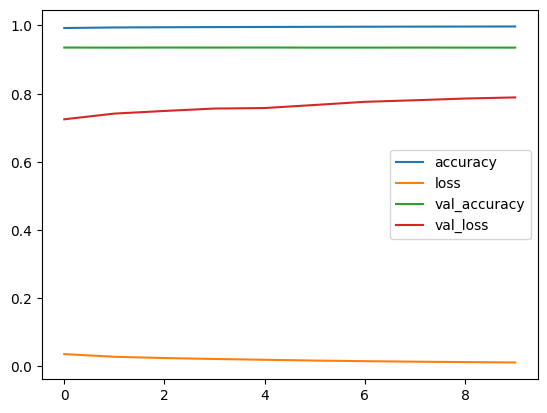

In [50]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

In [52]:
# 모델 저장
decoder_teacher_forcing_model.save('decoder_teacher_forcing_model.keras')

In [53]:
# 모델 로드
from tensorflow.keras.models import load_model
decoder_teacher_forcing_model_ = load_model('decoder_teacher_forcing_model.keras')

### 모델 추론

encoder + decoder(inference) 구조의 모델로 추론

##### 디코더 추론 모델

In [57]:
# 입력 states (이전 timestep외 hidden_state, cell_state)
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))
decoder_cell_state = layers.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]

# 토큰 입력 (이전 timestep의 output)
decoder_single_input = layers.Input(shape=(1,))

# 학습된 임베딩
x = ko_embedding_layer(decoder_single_input)

# 학습된 LSTM
x, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h, c]

decoder_outputs_ = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_states_inputs,
    outputs=[decoder_outputs_] + decoder_states
)
decoder_inference_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │    828,900 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 512),  │  1,255,424 │ embedding_1[2][0… │
│                     │ (None, 512),      │            │ input_layer_5[0]… │
│                     │ (None, 512)]      │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 8289)   │  4,252,257 │ lstm_1[2][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,336,581 (24.17 MB)

 Trainable params: 6,336,581 (24.17 MB)

 Non-trainable params: 0 (0.00 B)

##### 추론 함수

In [ ]:
def translate(input_seq):
    # 인코더 
    # input_seq 통과(추론) -> hidden_state, cell_state만 반환
    encoder_states_value = encoder_model.predict(input_seq)
    decoder_states_value = encoder_states_value     # 초기값

    # 디코더
    # 1. <sos><eos>
    sos_index = kor_tokenizer.word_index['<sos>']
    eos_index = kor_tokenizer.word_index['<eos>']

    # 2. target_seq 준비 (디코더 출력)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sos_index

    # 3. 순차적으로 디코딩(= 번역)
    output_sentence= []

    for _ in range(kor_max_len):
        output_tokens, h, c = decoder_inference_model.predict([target_seq] + decoder_states_value)

        pred_proba = output_tokens[0, 0, :]
        pred_index = np.argmax(pred_proba)

        if pred_index == eos_index:
            break

        if pred_index > 0:
            word = kor_tokenizer.index_word[pred_index]
            output_sentence.append(word)
        
        target_seq[0, 0] = pred_index
        decoder_states_value = [h, c]

    return ' '.join(output_sentence)

In [74]:
print(eng_inputs[:1])

input_seq = eng_inputs_padded[:1]
output_sent = translate(input_seq)

print(output_sent)


['Go.']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
가.


In [75]:
for _ in range(5):
    idx = np.random.choice(len(eng_inputs_padded))
    input_seq = eng_inputs_padded[idx:idx+1]
    output_sent = translate(input_seq)
    print("입력 영문:", eng_inputs[idx])
    print("학습된 국문:", kor_inputs[idx])
    print('추론한 국문', output_sent)
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
입력 영문: Take it easy!
학습된 국문: <sos> 걱정 마!
추론한 국문 진정해!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
입력 영문: It may take over an hour.
학습된 국문: <sos> 한 시간 넘게 걸릴 것 같아.
추론한 국문 한 시간 넘게 걸릴 것 같아.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
입력 영문: You finally succeeded in getting a job.
학습된 국문: <sos

In [76]:
def translate_eng2kor(eng_text):
    # 입력 데이터 전처리
    input_seq = eng_tokenizer.texts_to_sequences(eng_text)
    input_seq = pad_sequences(input_seq, maxlen=eng_max_len)
    return translate(input_seq) # 추론 함수 추출
eng_texts = [
    'My libs are red.',
    'French is interasting',
    'I like bus',
    "let\'s study",
    'I ate sandwich'    
]

for eng_text in eng_texts:
    kor_text = translate_eng2kor([eng_text])
    display(eng_text, kor_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


'My libs are red.'

'내 가방은 비어 있다.'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


'French is interasting'

'프랑스어는 흥미로워.'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


'I like bus'

'나 나 잃었다.'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


"let's study"

'당신은 읽어.'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


'I ate sandwich'

'나는 셀러리가 좋다.'